In [2]:
#!/usr/bin/python
import sys
sys.path.insert(0, '../Newby-tools/utilities')
import numpy as np
import math as ma
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import scipy as sc
from astropy.coordinates import SkyCoord
from dustmaps.config import config
import copy
config['data_dir'] = '/home/weissj3/Desktop/MWTools/Data'

import dustmaps.sfd
dustmaps.sfd.fetch()

MU_POINTS = 25
arcmintodegree = 0.0166667


deg = 180.0 / ma.pi
rad = ma.pi / 180.0 
lCP = 122.932 * rad #123.932 is the wrong value in B&M
surveyCenterRa = 185.0
surveyCenterDec = 32.5
raGP = 192.8594813 * rad
decGP = 27.1282511 * rad
arr = sc.array([0.0])
dsun = 8.5  # 8.0 is current IAU standard!

def checkGlobularClusters():
    clusters = [ [], [], [], [] ]
    
    f = open("/home/weissj3/Desktop/HarrisCatalog.txt", 'r')
    #File Format 46-51 and 53-58
    
    for line in f:
        if line[46:51] != "     " and  line[53:58] != "     " and line[60:64] != "    ":
            templ, tempb, tempr = float(line[46:51]), float(line[53:58]), float(line[60:64])
            
            if templ > 40 and templ < 210 and tempb < -30 and tempb > -80:
                clusters[0].append(templ)
                clusters[1].append(tempb)
                clusters[2].append(getg(tempr))
                clusters[3].append(line[1:9])
                print(line[1:9], templ, tempb, tempr)
                
        
    return clusters

def getg (r, M=4.2):
    #"""converts a distance (kpc) into a magnitude"""
    return M + 5.*(sc.log10(r*1000) - 1.)

def readStarFile_lb(x):
    f = open(x, 'r');
    f.readline()
    stars2 = np.array([ list(map(float, ln.replace(',', '').split())) for ln in f ])
    return stars2[:,0].tolist(), stars2[:,1].tolist(), stars2[:,2].tolist()

def lb2GC(l, b, wedge):
    ra, dec = lbToEq(l, b)
    return EqToGC(ra, dec, wedge)

def GC2lbr(mu, nu, r, wedge):
    ra, dec = GCToEq(mu, nu, wedge)
    l, b = EqTolb(ra, dec)
    return l,b,r
    
def GCToEq (mu_deg, nu_deg, wedge):  # produces lists....  ROTATE
    #""" Converts Stripe mu, nu into equatorial ra, dec.  Called 'atGCToEq' in at SurveyGeometry.c"""
    node = (surveyCenterRa - 90.0)*rad
    eta = get_eta(wedge)
    inc = (surveyCenterDec + eta)*rad
    mu, nu = (mu_deg*rad), (nu_deg*rad)
    # Rotation
    x2 = sc.cos(mu - node)*sc.cos(nu)
    y2 = sc.sin(mu - node)*sc.cos(nu)
    z2 = sc.sin(nu)
    x1 = x2
    y1 = y2*sc.cos(inc) - z2*sc.sin(inc)
    z1 = y2*sc.sin(inc) + z2*sc.cos(inc)
    ra = sc.arctan2(y1,x1) + node
    dec = sc.arcsin(z1)
    dec, ra = angle_bounds2((dec*deg),(ra*deg))
    return ra, dec
    
def EqTolb (ra_deg, dec_deg):
    #""" Converts equatorial ra, dec, into galactic l,b;  from Binney and Merrifield, p. 31
    #following the method of http://star-www.st-and.ac.uk/~spd3/Teaching/AS3013/programs/radec2lb.f90
    #NOT QUITE - I use arctan2 method instead"""
    ra, dec = (ra_deg*rad), (dec_deg*rad)
    # Conversion Code
    r = (ra - raGP)
    b = sc.arcsin( sc.sin(decGP)*sc.sin(dec) + sc.cos(decGP)*sc.cos(dec)*sc.cos(r) )
    t = sc.arctan2((sc.cos(dec)*sc.sin(r)),
                   (sc.cos(decGP)*sc.sin(dec) - sc.sin(decGP)*sc.cos(dec)*sc.cos(r)) )
    l = (lCP - t)
    b, l = angle_bounds2((b*deg), (l*deg))
    return l, b
    
def lbToEq (l_deg, b_deg):   
    #""" Converts galactic l,b in to Equatorial ra, dec; from Binney and Merrifield, p. 31;  
    #l, b must be arrays of same shape"""
    l, b = (l_deg*rad), (b_deg*rad)
    # Conversion Code
    t = lCP - l
    dec = sc.arcsin(sc.sin(decGP)*sc.sin(b) + sc.cos(decGP)*sc.cos(b)*sc.cos(t) )
    r = sc.arctan2( (sc.cos(b)*sc.sin(t)),
                    ( (sc.cos(decGP)*sc.sin(b)) - (sc.sin(decGP)*sc.cos(b)*sc.cos(t)))  )
    if type(r) != type(arr):  r = sc.array([r])
    for i in range(len(r)):
        r[i] = angle_bounds((r[i] + raGP)*deg)
    return r, (dec*deg)

def angle_bounds (angle, min=0.0, max=360.0):
    #""" Keeps an angle, in degrees, in a 360 degree region"""
    while angle < min:  angle = angle + 360.0
    while angle > max:  angle = angle - 360.0
    return angle

def angle_bounds2 (theta, phi):
    #""" Sets two spherical angles in bounds, -90<theta<90; 0<phi<360"""
    if type(theta) != type(arr):  theta = sc.array([theta])
    if type(phi) != type(arr):  phi = sc.array([phi])
    for i in range(len(theta)):
        theta[i] = angle_bounds(theta[i], -180.0, 180.0)
    for i in range(len(theta)):
        if sc.fabs(theta[i]) > 90.0:
            theta[i] = 180.0 - theta[i]
            phi[i] = phi[i] + 180.0
    for i in range(len(theta)):
        theta[i] = angle_bounds(theta[i], -180.0, 180.0)
        phi[i] = angle_bounds(phi[i], 0.0, 360.0)
    for i in range(len(theta)):
        if (sc.fabs(theta[i]) == 90.0):  phi[i] = 0.0
    if len(theta)==1:
        theta, phi = theta[0], phi[0]
    return theta, phi

def get_eta (wedge):
    #""" Get the eta value that corresponds to the given stripe value """  #wedge_eta?
    ss = 2.5
    if wedge <= 46:  eta = wedge * ss - 57.5
    else:  eta = wedge * ss - 57.5 - 180.0
    return eta

def EqToGC (ra_deg, dec_deg, wedge):  #produces lists...  anglebounds2!!!  ROTATE
    #""" Converts equatorial ra,dec into Great Circle mu, nu; 'atSurveyGeometry.c' in
    #m31.phys.rpi.edu:/p/prd/astrotools/v5_18/Linux-2-4-2-3-2/src"""
    node = (surveyCenterRa - 90.0)*rad
    eta = get_eta(wedge)
    inc = (surveyCenterDec + eta)*rad
    ra, dec = (ra_deg*rad), (dec_deg*rad)
    # Rotation
    x1 = sc.cos(ra-node)*sc.cos(dec)
    y1 = sc.sin(ra-node)*sc.cos(dec)
    z1 = sc.sin(dec)
    x2 = x1
    y2 = y1*sc.cos(inc) + z1*sc.sin(inc)
    z2 = -y1*sc.sin(inc) + z1*sc.cos(inc)
    mu = sc.arctan2(y2,x2) + node
    nu = sc.arcsin(z2)
    nu, mu = angle_bounds2((nu*deg), (mu*deg))
    return mu,nu

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


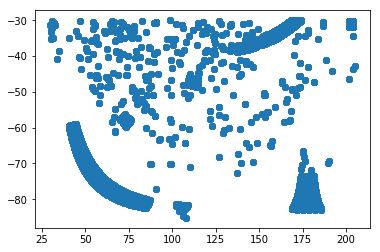

In [7]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii

Mask = dict()
Mask["Hole"] = dict(ascii.read("../Data/SDSSSkyHoleMask.csv"))
Mask["Bright"] = dict(ascii.read("../Data/SDSSSkyBrightMask.csv"))
Mask["Bleed"] = dict(ascii.read("../Data/SDSSSkyBleedMask.csv"))
Mask["Trail"] = dict(ascii.read("../Data/SDSSSkyTrailMask.csv"))
for i in Mask:
    Mask[i]["Skycoord"] = SkyCoord(Mask[i]["ra"], Mask[i]["dec"], frame='icrs', unit='deg').transform_to('galactic')
    c_mask = Mask[i]["Skycoord"].b < (-30 * u.deg)
    for j in dict(Mask[i]):
        Mask[i][j] = Mask[i][j][c_mask]  
    
plt.plot(Mask["Hole"]["Skycoord"].l, Mask["Hole"]["Skycoord"].b, 'o')
plt.show()

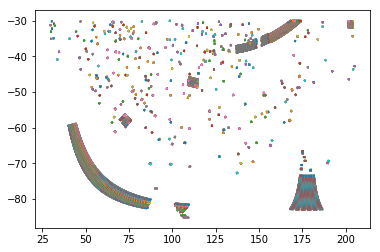

In [8]:
for i in Mask["Hole"]["area"]:
    verts = list(map(float, i.split(" ")[2:]))
    ra = verts[0:len(verts):2]
    dec = verts[1:len(verts):2]
    c = SkyCoord(ra, dec, frame='icrs', unit='deg').transform_to('galactic')
    plt.plot(c.l, c.b)
        
        

In [3]:
def PlotMask(SDSSMask, rows, cols, stripeMin, stripeMax):
    for i in range(stripeMin, stripeMax+1):
        ax1 = plt.subplot(rows,cols,i-(stripeMin-1))
        
        temp1, temp2 = lb2GC(np.array(SDSSMask.l), np.array(SDSSMask.b), i)

        if stripeMin > 70:
            for j in range(len(temp1)):
                if temp1[j] < 150:
                    temp1[j] = temp1[j] + 360.0
        
        mask = (temp2 > -1.25) & (temp2 < 1.25)
        temp1 = temp1[mask]
        #temp2 = temp2[mask]
        
        MuMin, MuMax = min(temp1), max(temp1)
        
        bins = np.linspace(MuMin, MuMax)
        
        #plt.hist(temp1, bins=int((MuMax - MuMin)/3), color='r', alpha=0.5)
        #ax2.set_ylim([0, 0.02])
        
        plt.plot(muPoints, , 'g-', ms=1)
        
        #ax1.set_ylim([0.0, 45.7])
        #ax1.plot(muPoints, rollingAvgCompleteness, 'g-', ms=1)
        plt.title("Stripe %d" % i)
        if int((i - (stripeMin)) / cols) == rows-1:
            plt.xlabel("Mu")
        if ((i - (stripeMin-1)) % cols) == 1:
            plt.ylabel("R")

SyntaxError: invalid syntax (<ipython-input-3-4adf00cfd1bf>, line 23)

In [10]:
plt.figure(1, figsize=(16, 10))
PlotMask(c_low["Hole"], 2, 4, 80, 86)
plt.figure(2, figsize=(16, 10))
PlotMask(c_low["Bright"], 2, 4, 80, 86)
plt.figure(3, figsize=(16, 10))
PlotMask(c_low["Trail"], 2, 4, 80, 86)

plt.show()


NameError: name 'PlotMask' is not defined

In [4]:
def PlotExtinctionAndStars(starFiles, rows, cols, stripeMin, stripeMax, method="average"):
    for i in range(stripeMin, stripeMax+1):
        ax1 = plt.subplot(rows,cols,i-(stripeMin-1))
        temp1, temp2, temp3 = readStarFile_lb(starFiles % i)
        if stripeMin > 70: temp = np.where((np.array(temp2) < -30.0))# & (np.array(temp3) > 30))# and (stars[2] > 24.0))
        else: temp = np.where((np.array(temp2) > 30.0))# & (np.array(temp3) > 30))
        temp1 = list(np.array(temp1)[temp])
        temp2 = list(np.array(temp2)[temp])
        temp3 = list(np.array(temp3)[temp])
        temp1, temp2 = lb2GC(np.array(temp1), np.array(temp2), i)
        
        if stripeMin > 70:
            for j in range(len(temp1)):
                if temp1[j] < 150:
                    temp1[j] = temp1[j] + 360.0
        MuMin, MuMax = min(temp1), max(temp1)

        muPoints = np.linspace(MuMin, MuMax, int(MuMax - MuMin)*10)

        nuPoints = []
        for j in np.linspace(-1.25,1.25, MU_POINTS):
            nuPoints.append([ float(j) for k in range(len(muPoints))])
        RPoints = [ 10.0 for i in range(len(muPoints))]

        Completeness = []
        for j in nuPoints:
            l, b, r = GC2lbr(np.array(muPoints), np.array(j), np.array(RPoints), i)

            coords = SkyCoord(l, b,  unit='deg', frame='galactic')

            sfd = dustmaps.sfd.SFDQuery()
            extinctionValues = sfd(coords) * 3.303 #3.303 is conversion from E(B-v) to sdss g
            Completeness.append([ma.pow(10.0, (22.5 - k - 4.2) / 5.0)/100.0 for k in extinctionValues])

        if method == "average":
            minCompleteness = [np.average(j) for j in np.transpose(Completeness)]
        elif method == "min":
            minCompleteness = [min(j) for j in np.transpose(Completeness)]
        elif method == "max":
            minCompleteness = [max(j) for j in np.transpose(Completeness)]
        else:
            print("Error: Invalid method.")
            return
        
        rollingAvgCompleteness = copy.deepcopy(minCompleteness)
        points = 11
        for j in range(int(points/2), len(minCompleteness) - int(points/2)):
            temp = 0.0
            for k in range(-int(points/2), int(points/2)+1):
                temp += minCompleteness[j + k]
                
            rollingAvgCompleteness[j] = temp / float(points)
            
        ax1.plot(temp1, temp3, 'o', color='blue', ms=0.1, alpha=0.5)
        
        #ax2 = ax1.twinx();
        
        #ax2.hist(temp1, bins=int((MuMax - MuMin)), density=True, color='r', alpha=0.5)
        #ax2.set_ylim([0, 0.02])
        
        ax1.set_ylim([0.0, 45.7])
        ax1.plot(muPoints, rollingAvgCompleteness, 'g-', ms=1)
        plt.title("Stripe %d" % i)
        if int((i - (stripeMin)) / cols) == rows-1:
            plt.xlabel("Mu")
        if ((i - (stripeMin-1)) % cols) == 1:
            plt.ylabel("R")
    plt.show()

In [ ]:
plt.figure(1, figsize=(16, 10))
PlotExtinctionAndStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars", 2, 4, 80, 86, "min")

In [ ]:
plt.figure(1, figsize=(16, 24))
PlotExtinctionAndStars("/home/weissj3/Desktop/MWTools/Data/milkyway_starfiles/stars-%d.txt", 4, 4, 9, 23, "min")

In [5]:
def CutStars(starFile, MuLims, RLims, NuLims, Cuts, stripe):
    l, b, r = readStarFile_lb(starFile)
    mu, nu = lb2GC(np.array(l), np.array(b), stripe)
    if stripe > 70:
        for j in range(len(mu)):
            if mu[j] < 150:
                mu[j] = mu[j] + 360.0
    mask = np.where((np.array(mu) > MuLims[0]) & (np.array(mu) < MuLims[1]) & (np.array(nu) > NuLims[0]) & (np.array(nu) < NuLims[1]) & (np.array(r) > RLims[0]) & (np.array(r) < RLims[1]))
    mu = np.array(mu)[mask]
    nu = np.array(nu)[mask]
    l = np.array(l)[mask]
    b = np.array(b)[mask]
    r = np.array(r)[mask]
    
    if Cuts != None:
        for i in Cuts:
            mask = np.where((np.array(mu) < i[0]) | (np.array(mu) > i[1]))
    
        mu = np.array(mu)[mask]
        nu = np.array(nu)[mask]
        l = np.array(l)[mask]
        b = np.array(b)[mask]
        r = np.array(r)[mask]
    
    f = open(starFile+".cut", "w");
    
    f.write(str(len(l))+"\n")
    for i in range(len(l)):
        f.write("%.6f %.6f %.6f\n" % (l[i], b[i], r[i]))
    
    
    

In [78]:
#MW@home First run cuts
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 80, [365, 395], [0,45.6], [-1.25,1.25], None, 80)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 81, [350, 400], [0,45.6], [-1.25,1.25], None, 81)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 82, [350, 400], [0,45.6], [-1.25,1.25], None, 82)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 83, [340, 400], [0,45.6], [-1.25,1.25], None, 83)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 84, [340, 400], [0,45.6], [-1.25,1.25], [[370,380]], 84)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 85, [340, 400], [0,45.6], [-1.25,1.25], [[370,380]], 85)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 86, [340, 400], [0,45.6], [-1.25,1.25], None, 86)

In [7]:
#MW@home Second run cuts
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 80, [365, 395], [0,45.6], [-1.25,1.25], None, 80)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 81, [350, 400], [0,45.6], [-1.25,1.25], None, 81)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 82, [350, 400], [0,45.6], [-1.25,1.25], None, 82)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 83, [350, 400], [0,45.6], [-1.25,1.25], None, 83)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 84, [350, 400], [0,45.6], [-1.25,1.25], [[370,380]], 84)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 85, [350, 400], [0,45.6], [-1.25,1.25], [[370,380]], 85)
CutStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % 86, [350, 400], [0,45.6], [-1.25,1.25], None, 86)

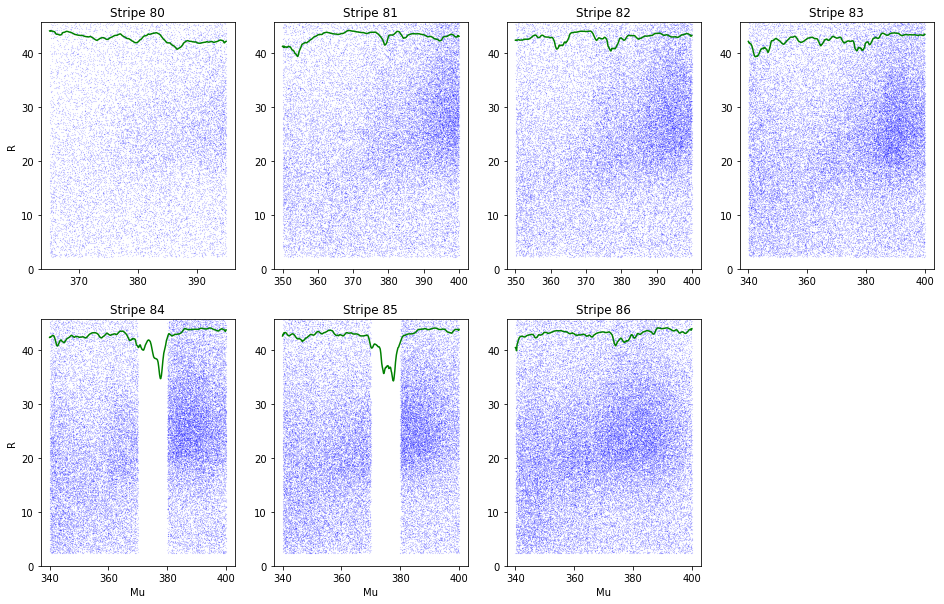

In [12]:
plt.figure(1, figsize=(16, 10))
PlotExtinctionAndStars("/home/weissj3/Desktop/SDSSSouth/stars-%d.txt", 2, 4, 80, 86, "min")

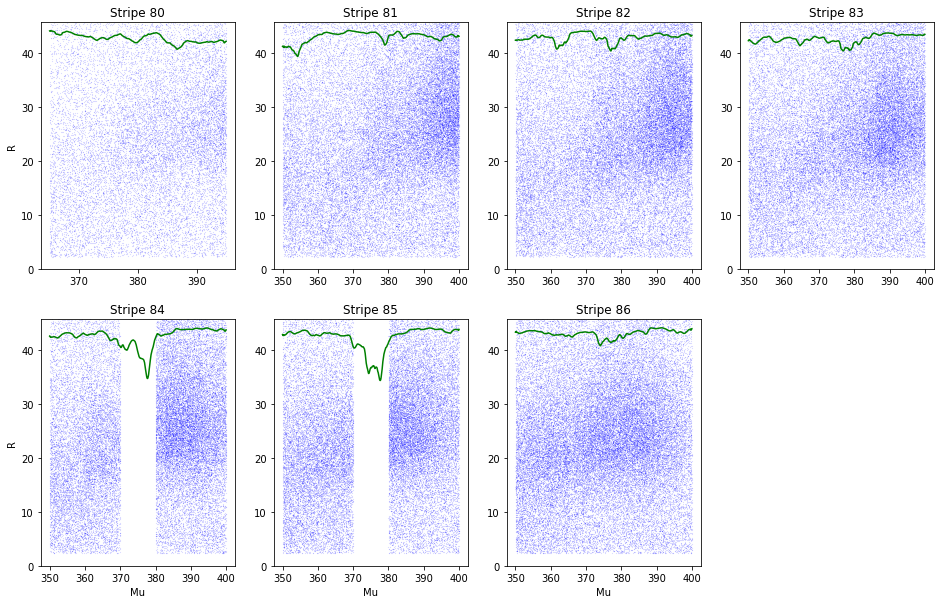

In [8]:
plt.figure(1, figsize=(16, 10))
PlotExtinctionAndStars("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars.cut", 2, 4, 80, 86, "min")